# ML Classification Project 

Members = {Zeyad Omar, Omar Wasif}<br>
IDs = {46-17779, 46-10701}<br>
Majors = {Communications, Communications}


### Import Libraries

In [70]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [47]:
import matplotlib.pyplot as plt

In [48]:
import warnings
warnings.filterwarnings('ignore')

### Read the dataset

The dataset is passed by the data cleaning pipeline in the `Data_Preprocessing` notebook <br>
the resultant data set is called `Clean_2011_Accidents_UK.csv` so we read it directly

In [49]:
df = pd.read_csv('Clean_2011_Accidents_UK.csv', index_col='accident_index')
df.head()

,accident_year,accident_reference,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,...,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,extracted_reference,day_number,week_number,season,is_weekend,hour,daytimegroup
accident_index,,,,,,,,,,,,,,,,,,,,,
201101BS70001,2011,01BS70001,-0.192203,0.146620,0.16377,1,1,1,13-01-11,Thursday,...,1,0,E01002812,01BS70001,3,-1.662733,Winter,0,0.485503,afternoon rush (15 - 19)
201101BS70002,2011,01BS70002,-0.165408,0.146615,0.16377,2,2,1,01-11-11,Tuesday,...,1,0,E01002819,01BS70002,1,1.158509,Autumn,0,1.075083,evening (19 - 23)
201101BS70003,2011,01BS70003,-0.170401,0.146061,0.16377,1,1,1,19-01-11,Wednesday,...,1,0,E01002914,01BS70003,2,-1.595560,Winter,0,0.682030,afternoon rush (15 - 19)
201101BS70005,2011,01BS70005,-0.194856,0.146817,0.16377,1,2,3,25-01-11,Tuesday,...,1,0,E01002813,01BS70005,1,-1.528388,Winter,0,1.861189,night (0 - 5)
201101BS70007,2011,01BS70007,-0.182783,0.145401,0.16377,1,2,1,01-06-11,Thursday,...,1,0,E01002913,01BS70007,3,-0.319284,Spring,0,-1.479763,morning rush (5 - 10)


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143976 entries, 201101BS70001 to 2.01198E+12
Data columns (total 40 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_year                                143976 non-null  int64  
 1   accident_reference                           143976 non-null  object 
 2   longitude                                    143976 non-null  float64
 3   latitude                                     143976 non-null  float64
 4   police_force                                 143976 non-null  float64
 5   accident_severity                            143976 non-null  int64  
 6   number_of_vehicles                           143976 non-null  int64  
 7   number_of_casualties                         143976 non-null  int64  
 8   date                                         143976 non-null  object 
 9   day_of_week                                  14

In [51]:
df.columns

Index(['accident_year', 'accident_reference', 'longitude', 'latitude',
       'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'extracted_reference',
       'day_number', 'week_number', 'season', 'is_weekend', 'hour',
       'daytimegroup'],
      dtype='object')

In [52]:
df.groupby(by = ['accident_severity'])['accident_severity'].count()/df.shape[0]

accident_severity
1    0.852031
2    0.137231
3    0.010738
Name: accident_severity, dtype: float64

It seems we have **imbalanced dataset** so we should avoid using the **accuracy** metric <br> 
We can use **F1 score** instead <br>
F1 Score for multiple classes is calculated per class and aggregated using the method `average` <br>
Which in our case `micro` which counts the total true positives, false negatives and false positives.

### Extracting relevant features

In [53]:
features =['longitude', 'latitude',
           'police_force', 'number_of_vehicles',
           'number_of_casualties', 'speed_limit',
           'pedestrian_crossing_human_control',
           'pedestrian_crossing_physical_facilities',
           'light_conditions', 'weather_conditions',
           'road_surface_conditions',
           'special_conditions_at_site', 'carriageway_hazards',
           'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
           'trunk_road_flag','day_number', 
           'week_number', 'is_weekend', 'hour']

In [54]:
labels = ['accident_severity']

In [55]:
X = df[features].values
y = df[labels].values

In [56]:
X.shape

(143976, 20)

In [57]:
y.shape

(143976, 1)

We have 143976 records each has 20 features

from preprocessing we chose Label encoding so lets check it has 3 classes

In [58]:
print(np.unique(y))

[1 2 3]


In [59]:
y-=1
print(np.unique(y))

[0 1 2]


the above step is for convenince

### Splitting the data for train and test

Since the dataset is imbalanced so it is important to split the data while maintaining the same ratio <br>
so we used the `stratify` keyword to split based on the output classes ratio

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y)

#### We split the data into 80% training and 20% testing

In [94]:
print("----------Train dataset----------")
print(X_train.shape)
print(y_train.shape)

print("------------Test dataset----------")
print(X_test.shape)
print(y_test.shape)


----------Train dataset----------
(115180, 20)
(115180, 1)
------------Test dataset----------
(28796, 20)
(28796, 1)


In [95]:
N_CLASSES = len(np.unique(y))
N_CLASSES

3

### KNN

In [96]:
X_test2, X_valid, y_test2, y_valid = train_test_split(X_test, y_test, train_size = 0.5, stratify = y_test)

In [97]:
Ks = range(2, 25)
scores = []
for K in Ks:
    knn = KNN(K)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_valid)

    scores.append(f1_score(y_pred, y_valid, average = 'micro'))

In [ ]:
plt.plot(Ks, scores)
plt.xlabel('Ks')
plt.ylabel('F1 Score')

We chose the F1-score to be our evaluation metric <br>
It seems that the optimal K is **10** and the highest f1 score is 0.85 <br>
Note: no need to take Ks values higher than 10 as f1 score is almost the same for them

In [64]:
knn = KNN(10)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test2)

f1_score(y_pred, y_test2, average = 'micro')

0.8497708015002083

The validation accuracy is almost the same as test accuracy

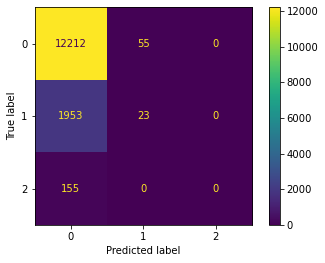

In [69]:
cm = confusion_matrix(y_test2, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

We can see that the model is biased towards the major class so we shouldn't rely on the accuracy as the evaluation metric

### Logistic Regression

For multi-class Classification Log-Reg uses the one-vs-rest technique

In [71]:
log_reg = LR(multi_class='ovr')
log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [72]:
y_pred = log_reg.predict(X_test)
f1_score(y_pred, y_test, average = 'micro')

0.8520280594527018

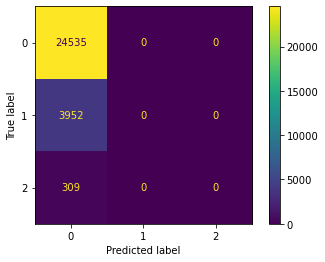

In [73]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Naive Bayes

We assumed the random variables have normal distribution

In [74]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [75]:
y_pred = gnb.predict(X_test)
f1_score(y_pred, y_test, average = 'micro')

0.7913599110987637

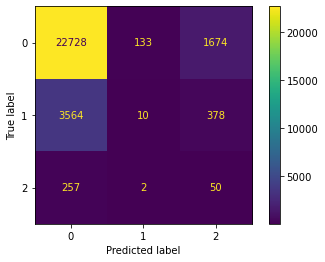

In [76]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Neural Network

In [77]:
input_shape = (X_train.shape[1])

In [78]:
N_CLASSES

3

It is easier to use one hot encoding for this model as it the NN outputs the probability of belonging to each class of the 3

In [90]:
y_train = np_utils.to_categorical(y_train, num_classes=N_CLASSES)
y_test = np_utils.to_categorical(y_test, num_classes=N_CLASSES)

print(y_train.shape)


(115180, 3)


In [80]:

 
def baseline_model():
    model = Sequential()
    model.add(Dense(3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer = Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    return model
 
estimator = KerasClassifier(build_fn=baseline_model,
                            epochs=10,
                            batch_size=256,
                            verbose=1.)
                            



We are using K-fold cross-validation where we split the Training data into 5 parts and train on 4 then validate on the 5th

In [27]:
kfold = KFold(n_splits=5, shuffle=True)


In [28]:
results = cross_val_score(estimator, X_train, y_train, cv=kfold)


Epoch 1/10
360/360 [==============================] - 2s 2ms/step - loss: 0.4636 - accuracy: 0.8492
Epoch 2/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4478 - accuracy: 0.8521
Epoch 3/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4467 - accuracy: 0.8521
Epoch 4/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4459 - accuracy: 0.8521
Epoch 5/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4455 - accuracy: 0.8521
Epoch 6/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4452 - accuracy: 0.8521
Epoch 7/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4448 - accuracy: 0.8521
Epoch 8/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4442 - accuracy: 0.8521
Epoch 9/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4443 - accuracy: 0.8521
Epoch 10/10
90/90 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.8518
E

In [29]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 85.20% (0.18%)


percentages:- <br>
<br>
class 0 :  85.2% <br>
class 1 :  13.7% <br>
class 2 :  1.07% <br>
so class 1 is almost 7 times less present in class 0 and class 2 is 85 times less present

In [81]:
weights = {0: 1,
           1: 7,
           2: 85}

history = estimator.fit(X_train, y_train, class_weight=weights)

Epoch 1/10
450/450 [==============================] - 2s 4ms/step - loss: 3.0067 - accuracy: 0.1635
Epoch 2/10
450/450 [==============================] - 2s 4ms/step - loss: 2.9490 - accuracy: 0.2769
Epoch 3/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8660 - accuracy: 0.4269
Epoch 4/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8473 - accuracy: 0.4190
Epoch 5/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8403 - accuracy: 0.4155
Epoch 6/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8355 - accuracy: 0.4158
Epoch 7/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8317 - accuracy: 0.4256
Epoch 8/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8299 - accuracy: 0.4168
Epoch 9/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8273 - accuracy: 0.4219
Epoch 10/10
450/450 [==============================] - 2s 4ms/step - loss: 2.8270 - accuracy: 0.4307

In [84]:
y_pred = estimator.predict(X_test)
y_test = np.argmax(y_test, axis = 1)
f1_score(y_pred, y_test, average = 'micro')

0.43353243506042505

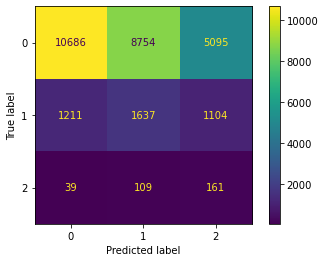

In [85]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

To see the effect of the class weights we can retrain the model without class weights and plot the confussion matrix

In [86]:
estimator = KerasClassifier(build_fn=baseline_model,
                            epochs=10,
                            batch_size=256,
                            verbose=1.)
                            
history = estimator.fit(X_train, y_train)

Epoch 1/10
450/450 [==============================] - 2s 4ms/step - loss: 0.6176 - accuracy: 0.7731
Epoch 2/10
450/450 [==============================] - 2s 3ms/step - loss: 0.4627 - accuracy: 0.8520
Epoch 3/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4543 - accuracy: 0.8520
Epoch 4/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4510 - accuracy: 0.8520
Epoch 5/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4492 - accuracy: 0.8520
Epoch 6/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4481 - accuracy: 0.8520
Epoch 7/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4475 - accuracy: 0.8520
Epoch 8/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4471 - accuracy: 0.8520
Epoch 9/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4469 - accuracy: 0.8520
Epoch 10/10
450/450 [==============================] - 1s 3ms/step - loss: 0.4466 - accuracy: 0.8520

In [91]:
y_pred = estimator.predict(X_test)
y_test = np.argmax(y_test, axis = 1)
f1_score(y_pred, y_test, average = 'micro')

0.8520280594527018

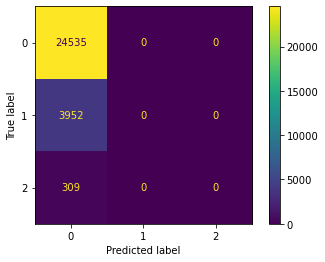

In [92]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

We can see that the model is overfitting to the majority class (always predicting 0)

Text(0, 0.5, 'Loss')

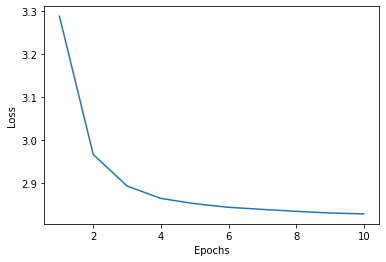

In [30]:
losses = history.history['loss']
accuracy = history.history['accuracy']
plt.plot(range(1, 11), losses)
plt.xlabel("Epochs")
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

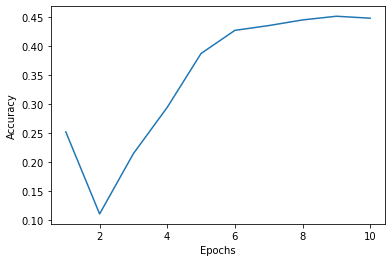

In [32]:
plt.plot(range(1, 11), accuracy)
plt.xlabel("Epochs")
plt.ylabel('Accuracy')

We tried several Hyper-parameters and the best result we got was 0.48 for f1 score. <br>
<br>
**Hyper-parameters** we tried:- <br>
- 3, 4, 5 ... Hidden layers ==> we found that more than 2 led to overfitting
- learning rate  > 0.001 ==>     made the optimizer diverge
- number of neurons for the first layer > 3 ==>  led to overfitting


### Models Comparison

<table ><tr><th >Model <th><th >KNN <th><th> Log_Reg <th><th>Naive_Bayes<th><th> NeuralNet <th><tr>
<tr><td>F1 Score<td><td> 0.85 <td><td> 0.85 <td><td> 0.80 <td><td> 0.45 <td><tr><table>

We can see that the f1 scores of both KNN and Log_Reg were almost the same <br>
and the performance of the Naive Bayes was lower than KNN and Log Reg but higher than NN

The evaluation metric we used seems to be misleading as the all models were predicting the majority class only and ignoring other classes, this can be seen from the confusion matrices above. <br>
The only useful model was the weighted neural network that managed to predict the minority classes correctly